In [2]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime,timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

### Collecting Data

In [4]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
print(df.shape)
df

(144, 1)


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


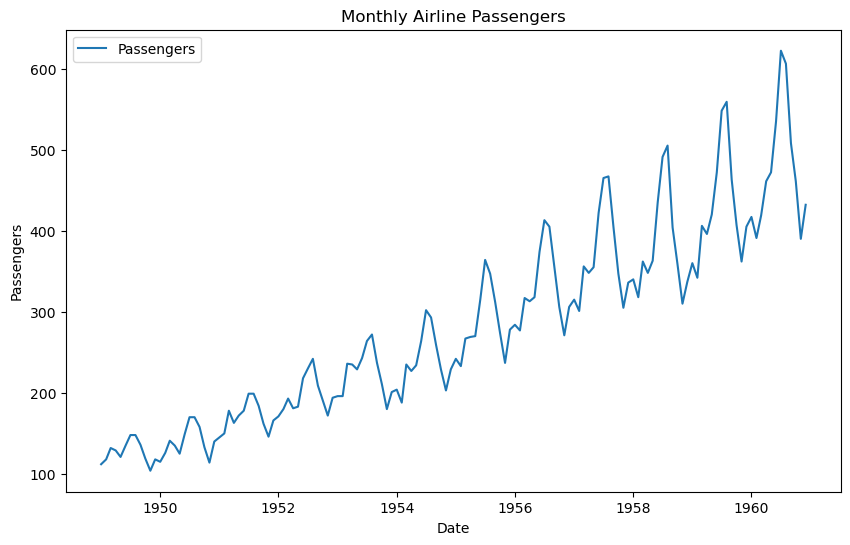

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Passengers'], label='Passengers')
plt.title('Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### Data Prepration

In [10]:
df.isnull().sum()

Passengers    0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [14]:
### checking stationary condition for data
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis. Data is non-stationary ")

In [16]:
adf_test(df['Passengers'])

ADF Statistics: 0.8153688792060371
p- value: 0.9918802434376408
weak evidence against null hypothesis. Data is non-stationary 


In [18]:
## Use Techniques Differencing
df['Passengers First Difference'] = df['Passengers'] - df['Passengers'].shift(1)

In [20]:
adf_test(df['Passengers First Difference'].dropna())

ADF Statistics: -2.829266824169981
p- value: 0.05421329028382793
weak evidence against null hypothesis. Data is non-stationary 


In [22]:
df['Passengers Second Difference'] = df['Passengers First Difference'] - df['Passengers First Difference'].shift(1)

In [24]:
adf_test(df['Passengers Second Difference'].dropna())

ADF Statistics: -16.384231542468505
p- value: 2.73289185001424e-29
strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary


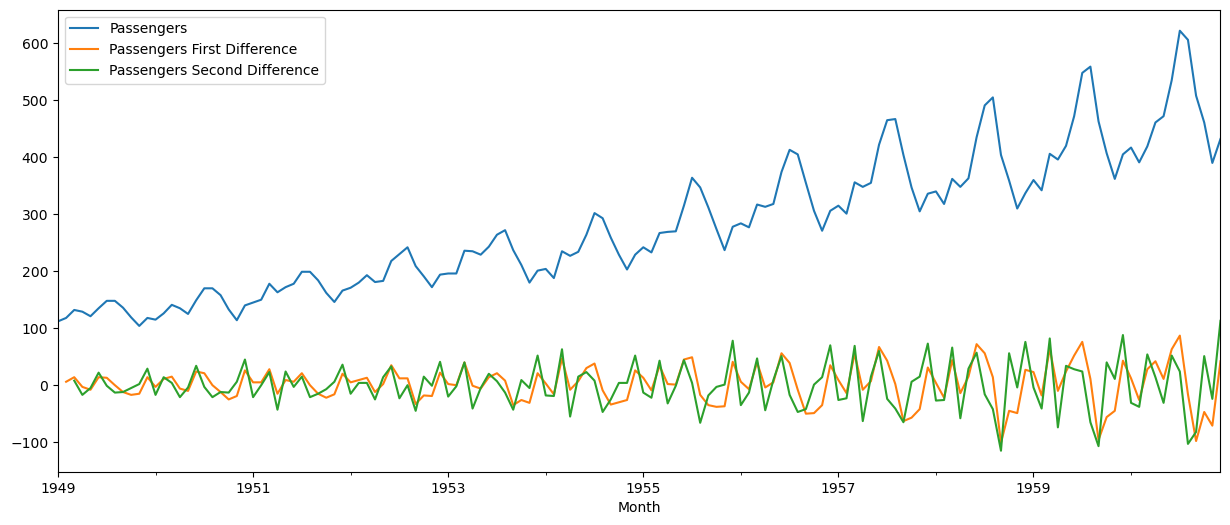

In [26]:
df.plot(figsize=(15, 6))
plt.show()

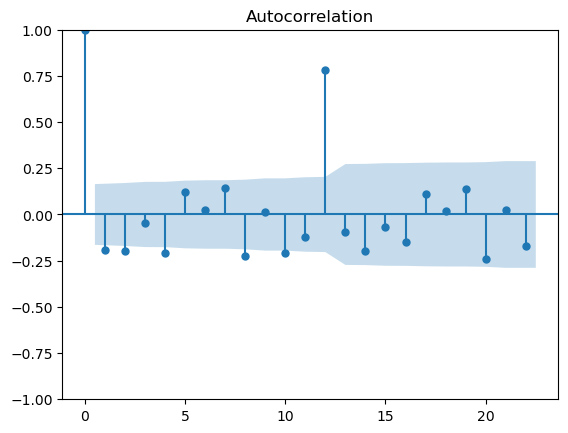

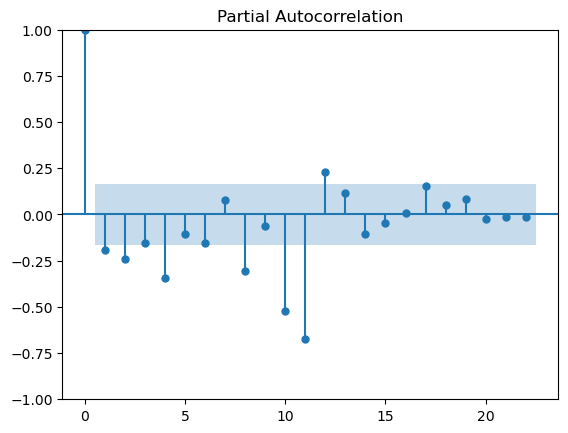

In [28]:
acf = plot_acf(df["Passengers Second Difference"].dropna())
pacf = plot_pacf(df["Passengers Second Difference"].dropna())

In [30]:
df['Passengers 12 Difference'] = df['Passengers'] - df['Passengers'].shift(12)

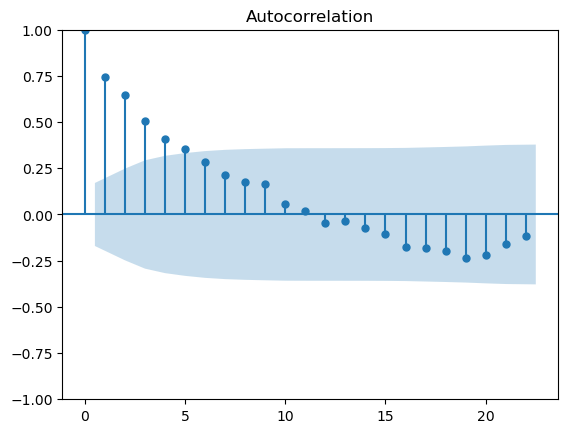

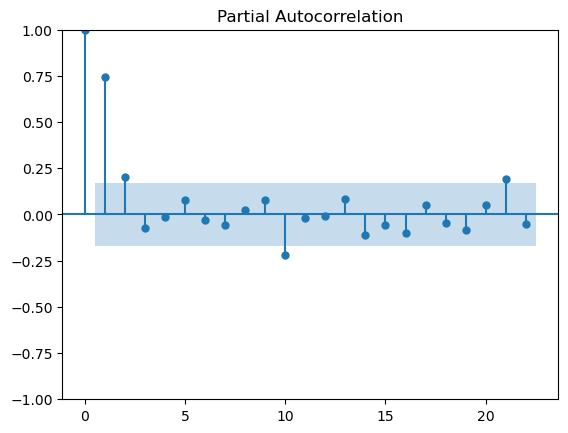

In [32]:
acf12 = plot_acf(df["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df["Passengers 12 Difference"].dropna())

### Feature Engineering

In [35]:
# Create lags for the past 12 months
for lag in range(1, 13):  
    df[f'Lag_{lag}'] = df['Passengers'].shift(lag)

# Create rolling statistics
df['Rolling_Mean'] = df['Passengers'].rolling(window=12).mean()
df['Rolling_Std'] = df['Passengers'].rolling(window=12).std()

# Create date-based features
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year
df['Day_of_Week'] = df.index.dayofweek

# Create Fourier terms for seasonality
for period in [12, 6]:  # Annual and semi-annual seasonality
    df[f'Sin_{period}'] = np.sin(2 * np.pi * df['Month'] / period)
    df[f'Cos_{period}'] = np.cos(2 * np.pi * df['Month'] / period)

# Drop NaN values created by shifting and rolling
df.dropna(inplace=True)
df.head()

,Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,...,Rolling_Mean,Rolling_Std,Month,Quarter,Year,Day_of_Week,Sin_12,Cos_12,Sin_6,Cos_6
Month,,,,,,,,,,,,,,,,,,,,,
1950-01-01,115,-3.0,-17.0,3.0,118.0,104.0,119.0,136.0,148.0,148.0,...,126.916667,13.453342,1,1,1950,6,0.500000,8.660254e-01,8.660254e-01,0.5
1950-02-01,126,11.0,14.0,8.0,115.0,118.0,104.0,119.0,136.0,148.0,...,127.583333,13.166475,2,1,1950,2,0.866025,5.000000e-01,8.660254e-01,-0.5
1950-03-01,141,15.0,4.0,9.0,126.0,115.0,118.0,104.0,119.0,136.0,...,128.333333,13.686977,3,1,1950,2,1.000000,6.123234e-17,1.224647e-16,-1.0
1950-04-01,135,-6.0,-21.0,6.0,141.0,126.0,115.0,118.0,104.0,119.0,...,128.833333,13.822467,4,2,1950,5,0.866025,-5.000000e-01,-8.660254e-01,-0.5
1950-05-01,125,-10.0,-4.0,4.0,135.0,141.0,126.0,115.0,118.0,104.0,...,129.166667,13.663710,5,2,1950,0,0.500000,-8.660254e-01,-8.660254e-01,0.5


### Split data to Train & Test

In [38]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (105, 26)
Test shape: (27, 26)


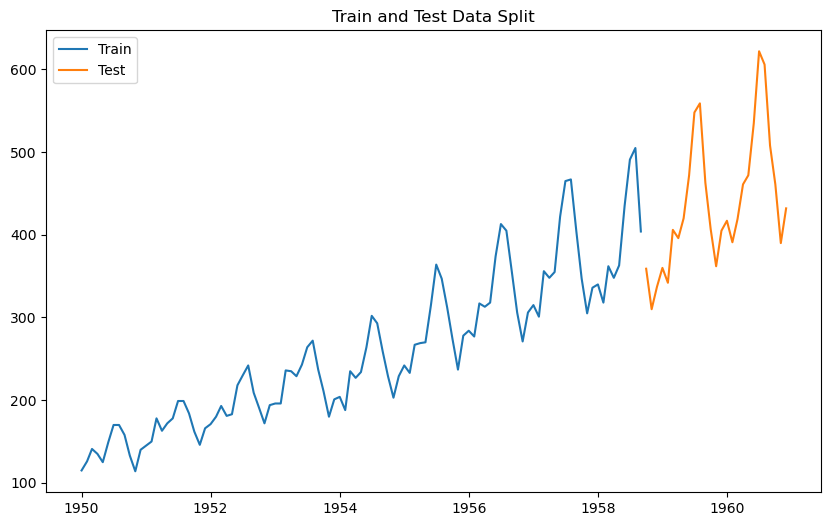

In [40]:
# Plot train and test data
plt.figure(figsize=(10, 6))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.title('Train and Test Data Split')
plt.legend()
plt.show()

### Model Training & Forecasting

In [43]:
best_order = (3,0,5)
best_seasonal_order = (0,1,0,12)

# Fit the SARIMA model with the best parameters
model = SARIMAX(train['Passengers'], 
                order=best_order, 
                seasonal_order=best_seasonal_order,
                exog=train.drop(['Passengers', 'Passengers 12 Difference', 'Passengers First Difference','Passengers Second Difference'], axis=1))

model_fit = model.fit(disp=False)
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  105
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                 859.737
Date:                             Thu, 24 Oct 2024   AIC                          -1657.475
Time:                                     14:10:01   BIC                          -1578.964
Sample:                                 01-01-1950   HQIC                         -1625.775
                                      - 09-01-1958                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Lag_1           -1.0000   2.37e-21  -4.21e+20      0.000      -1.000      -1.000
Lag_2           -1.00

In [44]:
exog_test = test.drop(['Passengers', 'Passengers 12 Difference', 'Passengers First Difference','Passengers Second Difference'], axis=1)
predictions = model_fit.forecast(steps=len(test), exog=exog_test)

In [47]:
test['Predicted_SARIMA']=predictions

<Axes: xlabel='Month'>

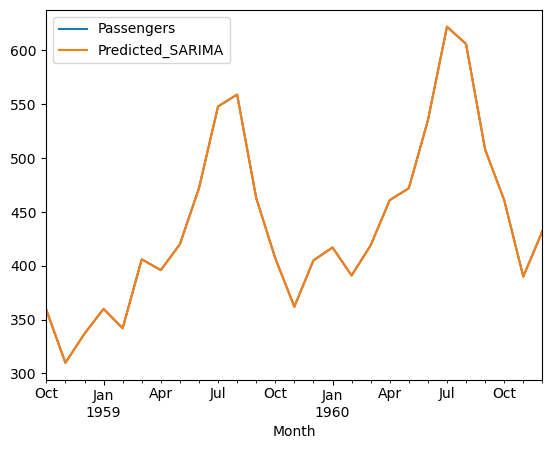

In [49]:
test[['Passengers','Predicted_SARIMA']].plot()

In [51]:
mse = mean_squared_error(test['Passengers'], predictions)
mape = mean_absolute_percentage_error(test['Passengers'], predictions)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

Mean Squared Error (MSE): 0.00
Mean Absolute Percentage Error (MAPE): 0.00%
